# Предсказание заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необхоимо построить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# 1. Подготовка данынх

In [1]:
import time
import datetime
from warnings import simplefilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

In [2]:
# Заменим индекс на колонку с датой-временем.
df = pd.read_csv('datasets/taxi.csv', parse_dates=[0], index_col=[0])

print(df.info)
df.head()
print('Минимальная дата заказа:', df.index.min(), '\n')
print('Максимальная дата заказа:', df.index.max())

<bound method DataFrame.info of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>
Минимальная дата заказа: 2018-03-01 00:00:00 

Максимальная дата заказа: 2018-08-31 23:50:00


## 2. Анализ

Поскольку данные представлены с интервалом в 10 мин., конвертируем их в часовые.

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


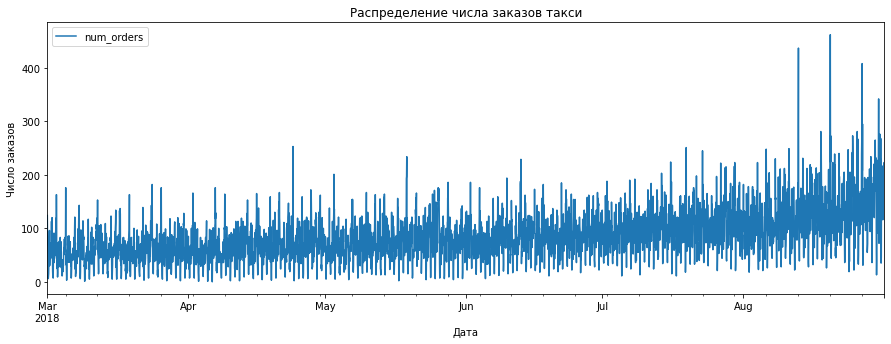

In [3]:
# Перед построением графика, отсортируем строки по индексу.
df.sort_index(inplace=True)


# Проведем ресемплинг данных, сгруппировав их по часам.
df_1h = df.resample('1H').sum()


df_1h.plot(figsize=(15,5),
           title='Распределение числа заказов такси',
           xlabel='Дата',
           ylabel='Число заказов')

display(df_1h.describe())

Преобразуем данные в дневные, чтобы изучить тренды.

,num_orders,mean
count,184.000000,178.000000
mean,2026.146739,2007.134029
std,635.874120,567.168831
min,1076.000000,1278.857143
25%,1547.500000,1561.321429
50%,1911.500000,1889.714286
75%,2349.750000,2381.571429
max,4090.000000,3703.714286


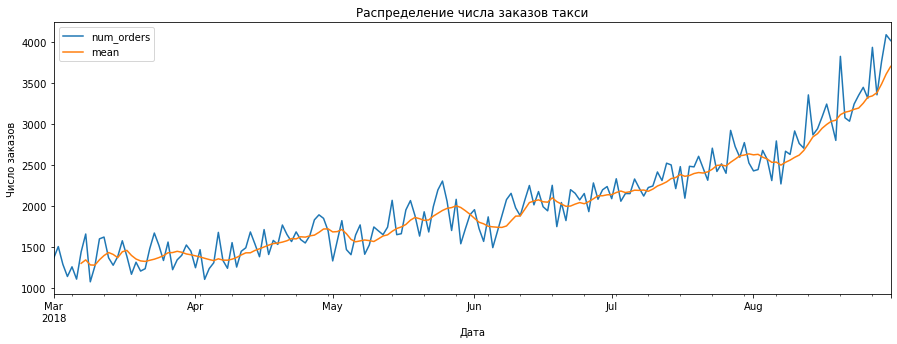

In [4]:
# Ресемплинг по дням.
df_1d = df.resample('1D').sum()

# Добавим 7-дневную MA.
df_1d['mean'] = df_1d['num_orders'].rolling(7).mean()

df_1d.plot(figsize=(15,5),
           title='Распределение числа заказов такси',
           xlabel='Дата',
           ylabel='Число заказов')

display(df_1d.describe())

Данные представлены за 6 месяцев 2018 года. В какой-то час поступило 462 заказа (максимальное значение), что выглядит странным, при медиане 78 и 75м процентиле 107 заказов в час.
<br>Наблюдается увеличение числа заказов такси в летний период (с июля). Возможно, это объясняется не только сезонной составляющей, но и ростом бизнеса.
<br>Рассмотрим данные в сплите по дням недели.

In [5]:
df_1d['dow_index'] = df_1d.index.dayofweek

def rename_dow(dow_index):
    if dow_index == 0:
        return 'Monday'
    elif dow_index == 1:
        return 'Tuesday'
    elif dow_index == 2:
        return 'Wednesday'
    elif dow_index == 3:
        return 'Thursday'
    elif dow_index == 4:
        return 'Friday'
    elif dow_index == 5:
        return 'Saturday'
    elif dow_index ==6:
        return 'Sunday'
    else:
        return 'N/A'
    
df_1d['dow'] = df_1d['dow_index'].apply(rename_dow)
df_1d = df_1d.drop(['dow_index'], axis=1)

dow
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
Name: num_orders, dtype: object

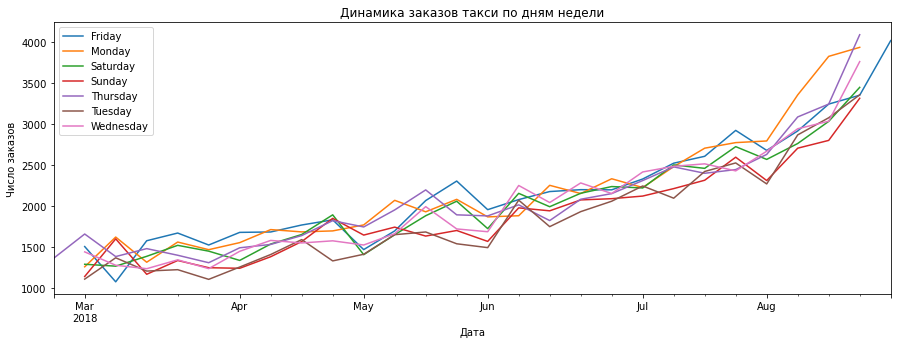

In [6]:
df_1d.groupby('dow')['num_orders'].plot(kind='line',
                                        legend=True,
                                        figsize=(15,5),
                                        title='Динамика заказов такси по дням недели',
                                        xlabel='Дата',
                                        ylabel='Число заказов')

В августе стало больше заказов такси по понедельникам. Также выбивается скачок в конце мая на пятничные заказы.
<br>На дневном таймфрейме выделим трендовый и сезонный компоненты, а также остатки.

<AxesSubplot:title={'center':'Тренд при декомпозиции числа заказов такси, 1D'}, xlabel='Дата', ylabel='Число заказов'>

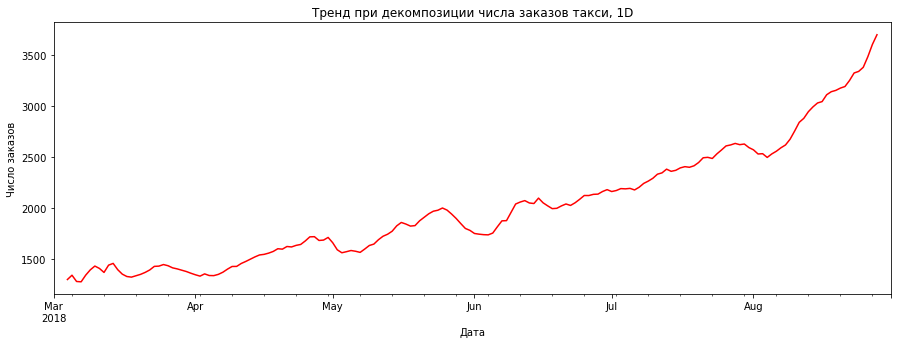

In [7]:
decomposed = seasonal_decompose(df_1d['num_orders'])

decomposed.trend.plot(figsize=(15,5),
                      title='Тренд при декомпозиции числа заказов такси, 1D',
                      xlabel='Дата',
                      ylabel='Число заказов',
                      color='r')

<AxesSubplot:title={'center':'Сезонность при декомпозиции числа заказов такси, 1D'}, xlabel='Дата', ylabel='Число заказов'>

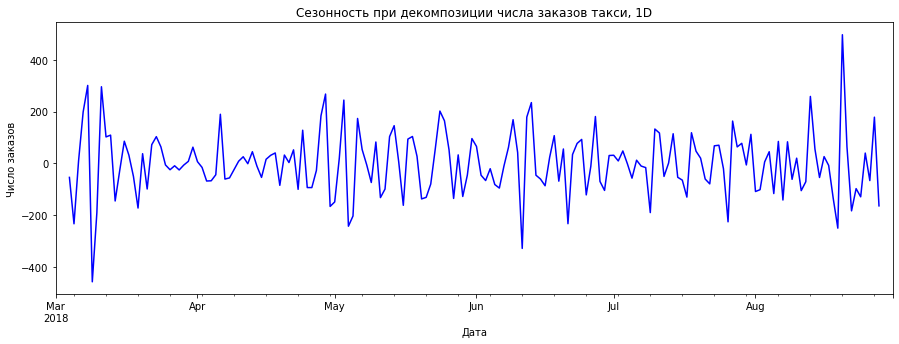

In [8]:
decomposed.resid.plot(figsize=(15,5),
                         title='Сезонность при декомпозиции числа заказов такси, 1D',
                         xlabel='Дата',
                         ylabel='Число заказов',
                         color='b')

Стандартное отклонение, заказов/день: 123.28196551996496


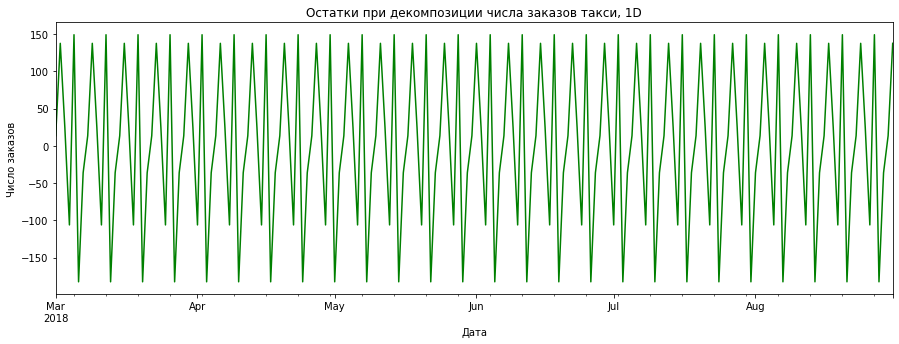

In [9]:
decomposed.seasonal.plot(figsize=(15,5),
                         title='Остатки при декомпозиции числа заказов такси, 1D',
                         xlabel='Дата',
                         ylabel='Число заказов',
                         color='g')

print('Стандартное отклонение, заказов/день:', decomposed.resid.std())

**Выводы**

- Восходящий тренд, который может быть как следствием сезонности, так и роста бизнеса. Для понимания природы роста, недостаточно данных, поскольку необходимо рассмотреть несколько лет, а не 6 мес датасета.
- Число заказов такси по понедельникам и пятницам посчити всегда выше, чем в остальные дни недели.
- Остаток декомпозиции по дням составляет 300 заказов и имеет стандарное отклонение 123 заказа.

## 3. Построение модели

Подготовим признаки и построим следующие модели:
- линейной регресси,
- LASSO,
- регрессии случайного леса,
- XGBRegressor,
- CatBoostRegressor.

Далее сравним их показатели RMSE на обучающей, валидационной и тестовой выборках.

### 3.1.  Подготовка признаков

Поскольку горизонт прогнозирования - час, в дальнейшей работе используем датасет с ресемплингом 1H.

Возьмем следующие признаки:
- день недели,
- сдвиг данных,
- 4-часовое скользящее среднее.

In [10]:
# Создадим функцию для подготовки датасета к анализу, используя календарные принаки, отстающие значения и MA.
# Значения изменения лага в 2 задает влияние тенденций последних 2 часов на текущий час.
# Скользящее среднее в 24 часа равно числу часов в сутках, значение взято субъективно, т.к. это не слишком большой временной промежуток для изменения дневного
# тренда, и не слишком маленький, чтобы создавать "шумы".


def make_features(data, max_lag, rolling_mean_size):
    data = pd.DataFrame(data)
    data['dow'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(df_1h, 2, 24)
df_1h.head()

,num_orders,dow,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN


Text(0.5, 1.0, 'Корреляционная матрица')

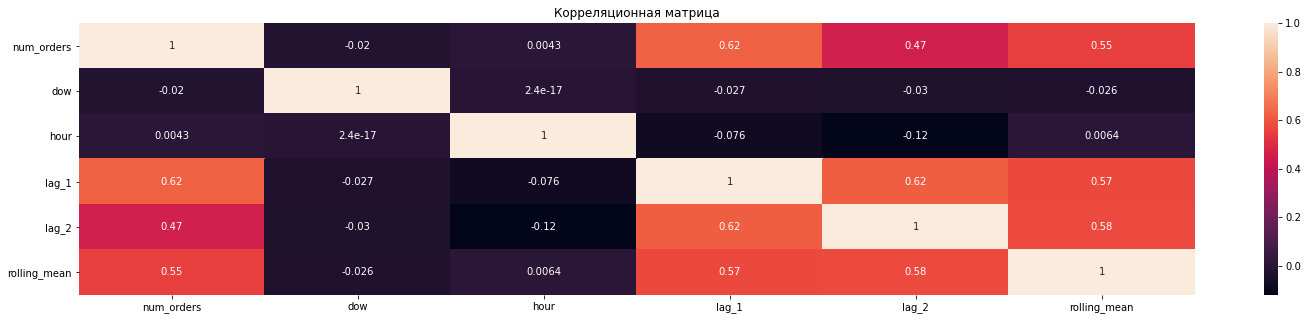

In [12]:
plt.figure(figsize=(25,5))
corr_matrix = sns.heatmap(df_1h.corr(),annot=True)
corr_matrix.axes.set_title("Корреляционная матрица")

<br>Дни недели и часы имеют самую слабую корреляцию. С другой стороны, авторегрессия во временных рядах имеет большое значение.
<br>Выделим признаки и целевой признак, а также разобьем датасет на обучающую, валидационную и тестовую выборки.

In [13]:
# Удалим пропуски, появившиеся при создании признаков.
df_1h = df_1h.dropna()

features = df_1h.drop(['num_orders'], axis=1)
target = df_1h['num_orders']

# Выделим тестовую выборку размером 10% от датасета.
(features_train,
 features_test,
 target_train,
 target_test) = train_test_split(features, target, test_size=0.1, random_state=12345)


# Раздедим оставшиеся данные на обучающую и валидационную выборки.
(features_train,
 features_valid,
 target_train,
 target_valid) = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)


# Проверим корерктность рассплитовки.
if features_train.shape[0] + features_valid.shape[0] + features_test.shape[0] == df_1h.shape[0]:
    print('Датасет раздлен на выборки корректно\n')
else:
    print('Датасет раздлен на выборки некорректно\n')

print('Исходный датасет включает:', df_1h.shape[0],
      '\nОбучающая выборка включает:', features_train.shape[0], f'или {features_train.shape[0]/df_1h.shape[0]:.1%} датасета'
      '\nВалидационная выборка включает:', features_valid.shape[0], f'или {features_valid.shape[0]/df_1h.shape[0]:.1%} датасета'
      '\nТестовая выборка включает:', features_test.shape[0], f'или {features_test.shape[0]/df_1h.shape[0]:.1%} датасета')

Датасет раздлен на выборки корректно

Исходный датасет включает: 4392 
Обучающая выборка включает: 2964 или 67.5% датасета
Валидационная выборка включает: 988 или 22.5% датасета
Тестовая выборка включает: 440 или 10.0% датасета


### 3.2. Обучение моделей

Подготовим функцию, которая будет:
- выполнять кросс-валидацию,
- обучать модель на лучших параметрах,
- проверять модель на валидационной выборке,
- замерять время обучения,
- замерять RMSE на обучающей и валидационной выборках.

In [14]:
# Словарь для хранения лучших параметров обученных моделей.
model_best_params = {}

# Словарь для хранения скорости обучения в секундах.
model_speed_train = {}

# Словарь для хранения RMSE на тесте.
model_score_train = {}

# Словарь для хранения RMSE на валидации.
model_score_valid = {}


def train_valid(model, params):
    # Переменная для хранения имени модели.
    name =[x for x in globals() if globals()[x] is model][0]
    train_start = time.time()
    GSCV = GridSearchCV(model,
                        params,
                        scoring='neg_mean_squared_error',
                        cv=TimeSeriesSplit(n_splits=5).split(features_train))
    
    
    GSCV.fit(features_train, target_train)
    train_time = time.time() - train_start
    
    valid_predictions = GSCV.predict(features_valid)
    RMSE_train = abs(GSCV.best_score_)**0.5
    RMSE_valid = mean_squared_error(valid_predictions, target_valid)**0.5
    
    print('Время обучения модели, сек.:', np.round_(train_time))
    print('RMSE лучшей модели на обучающей выборке:', RMSE_train)
    print('RMSE лучшей модели на валидационной выборке:', RMSE_valid)
    
    model_best_params[name] = GSCV.best_estimator_
    model_speed_train[name] = train_time
    model_score_train[name] = RMSE_train
    model_score_valid[name] = RMSE_valid
    
    return model_best_params, model_speed_train, model_score_train, model_score_valid

Ниже инициированы модели, каждая из которых, вместе с параметрами, передается в функцию `train_valid` для обучения, валидации и замера метрик. 

<u><b>Обучение линейной регрессии</b></u>

In [15]:
LR_model = LinearRegression()
LR_params = {'n_jobs':[1, 10, 20, 100]}

In [16]:
train_valid(LR_model, LR_params)

Время обучения модели, сек.: 0.0
RMSE лучшей модели на обучающей выборке: 33.40580551155084
RMSE лучшей модели на валидационной выборке: 35.63106602038267


({'LR_model': LinearRegression(n_jobs=1)},
 {'LR_model': 0.14435338973999023},
 {'LR_model': 33.40580551155084},
 {'LR_model': 35.63106602038267})

<u><b>Обучение LASSO</b></u>

In [17]:
LASSO_model = LassoCV()
LASSO_params = {}

In [18]:
train_valid(LASSO_model, LASSO_params)

Время обучения модели, сек.: 0.0
RMSE лучшей модели на обучающей выборке: 33.38922048554184
RMSE лучшей модели на валидационной выборке: 35.61587764340806


({'LR_model': LinearRegression(n_jobs=1), 'LASSO_model': LassoCV()},
 {'LR_model': 0.14435338973999023, 'LASSO_model': 0.4168579578399658},
 {'LR_model': 33.40580551155084, 'LASSO_model': 33.38922048554184},
 {'LR_model': 35.63106602038267, 'LASSO_model': 35.61587764340806})

<u><b>Обучение регрессии случайного леса</b></u>

In [19]:
RFR_model = RandomForestRegressor()
RFR_params = {'max_depth':[1,10,20], 'n_estimators':[100,150,10], 'random_state':[12345]}

In [20]:
train_valid(RFR_model, RFR_params)

Время обучения модели, сек.: 16.0
RMSE лучшей модели на обучающей выборке: 26.830381569496378
RMSE лучшей модели на валидационной выборке: 28.013388172106005


({'LR_model': LinearRegression(n_jobs=1),
  'LASSO_model': LassoCV(),
  'RFR_model': RandomForestRegressor(max_depth=20, random_state=12345)},
 {'LR_model': 0.14435338973999023,
  'LASSO_model': 0.4168579578399658,
  'RFR_model': 16.1815242767334},
 {'LR_model': 33.40580551155084,
  'LASSO_model': 33.38922048554184,
  'RFR_model': 26.830381569496378},
 {'LR_model': 35.63106602038267,
  'LASSO_model': 35.61587764340806,
  'RFR_model': 28.013388172106005})

<u><b>Обучение LightGBM</b></u>

In [21]:
LGBR_model = LGBMRegressor()
LGBR_params = {'n_estimators': [10,50,100], 'max_depth': [15,30],'num_leaves': [10,20,31], 'learning_rate': [0.1]}

In [22]:
train_valid(LGBR_model, LGBR_params)

Время обучения модели, сек.: 4.0
RMSE лучшей модели на обучающей выборке: 26.093928788683883
RMSE лучшей модели на валидационной выборке: 26.7538103356835


({'LR_model': LinearRegression(n_jobs=1),
  'LASSO_model': LassoCV(),
  'RFR_model': RandomForestRegressor(max_depth=20, random_state=12345),
  'LGBR_model': LGBMRegressor(max_depth=15, num_leaves=10)},
 {'LR_model': 0.14435338973999023,
  'LASSO_model': 0.4168579578399658,
  'RFR_model': 16.1815242767334,
  'LGBR_model': 4.456556558609009},
 {'LR_model': 33.40580551155084,
  'LASSO_model': 33.38922048554184,
  'RFR_model': 26.830381569496378,
  'LGBR_model': 26.093928788683883},
 {'LR_model': 35.63106602038267,
  'LASSO_model': 35.61587764340806,
  'RFR_model': 28.013388172106005,
  'LGBR_model': 26.7538103356835})

<u><b>Обучение CatBoost</b></u>

In [23]:
CB_model = CatBoostRegressor()
CB_params = {'max_depth': [10,20], 'learning_rate': [0.1],'iterations': [10,50,100], 'verbose':[False]}

In [24]:
train_valid(CB_model, CB_params)

C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Roman\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Roman\anaconda3\lib\site-packages\catboost\core.py", line 5590, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "C:\Users\Roman\anaconda3\lib\site-packages\catboost\core.py", line 2262, in _fit
    train_params = self._

Время обучения модели, сек.: 14.0
RMSE лучшей модели на обучающей выборке: 26.13781452183238
RMSE лучшей модели на валидационной выборке: 26.691804360390925


({'LR_model': LinearRegression(n_jobs=1),
  'LASSO_model': LassoCV(),
  'RFR_model': RandomForestRegressor(max_depth=20, random_state=12345),
  'LGBR_model': LGBMRegressor(max_depth=15, num_leaves=10),
  'CB_model': <catboost.core.CatBoostRegressor at 0x1d2abd92ee0>},
 {'LR_model': 0.14435338973999023,
  'LASSO_model': 0.4168579578399658,
  'RFR_model': 16.1815242767334,
  'LGBR_model': 4.456556558609009,
  'CB_model': 13.899219989776611},
 {'LR_model': 33.40580551155084,
  'LASSO_model': 33.38922048554184,
  'RFR_model': 26.830381569496378,
  'LGBR_model': 26.093928788683883,
  'CB_model': 26.13781452183238},
 {'LR_model': 35.63106602038267,
  'LASSO_model': 35.61587764340806,
  'RFR_model': 28.013388172106005,
  'LGBR_model': 26.7538103356835,
  'CB_model': 26.691804360390925})

**Выводы**

- Признаки для модели подготовлены.
- Выборка разбита на обучающую, валидационную и тестовую в пропорции 60/20/20.
- Обучено 5 моделей, для LinearRegression и Lasso наилучшие гиперпарметры не подбирались; для RandomForestRegression, LightGBM и CatBoost такая подборка была осуществлена.

### 3.3. Тестирование моделей

Ниже рассчитаны RMSE на тестовой выборке для каждой из 5 моделей, а также визуализирвоаны значения ее прогнозов и фактические значения целевого признака. 

In [25]:
# Словарь для хранения RMSE на тестовой выборке.
model_score_test = {}

# Функция для тестирования и вывода резульаттов.

def test_model(model, features_test, target_test):
    
    predictions = model.predict(features_test)
    RMSE = mean_squared_error(predictions, target_test) ** 0.5
    
    print('\033[1m' + 'Значение RMSE на тестовой выборке:' + '\033[0m', RMSE)
    
    
    # Визуализация.
    ax = pd.DataFrame(data={'Факт':target_test, 'Прогноз':predictions}).plot(figsize=(15, 5), color=['orange','g'], grid=True)
    ax.set_title('Число заказов такси')
    ax.set(ylabel='Заказов в час', xlabel='Дата')
    
    # Для отображения на графике только августа.
    ax.set_xlim([datetime.date(2018, 8, 1), datetime.date(2018, 8, 31)])
    

<u><b>Тестирование линейной регрессии</b></u>

Значение RMSE на тестовой выборке: 33.12746409471319


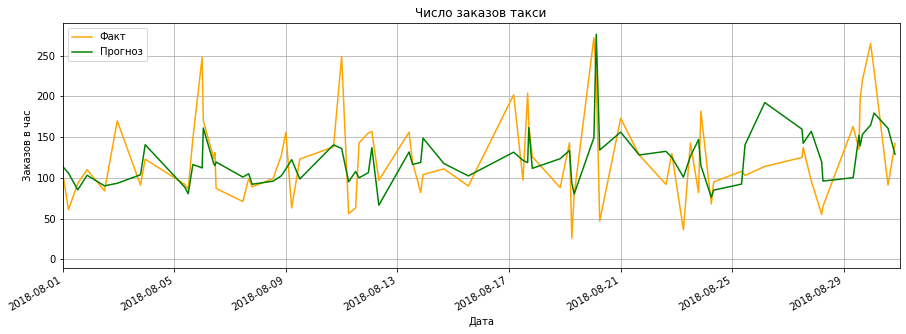

In [26]:
test_model(model_best_params['LR_model'], features_test, target_test)

<u><b>Тестирование LASSO</b></u>

Значение RMSE на тестовой выборке: 33.113099128770806


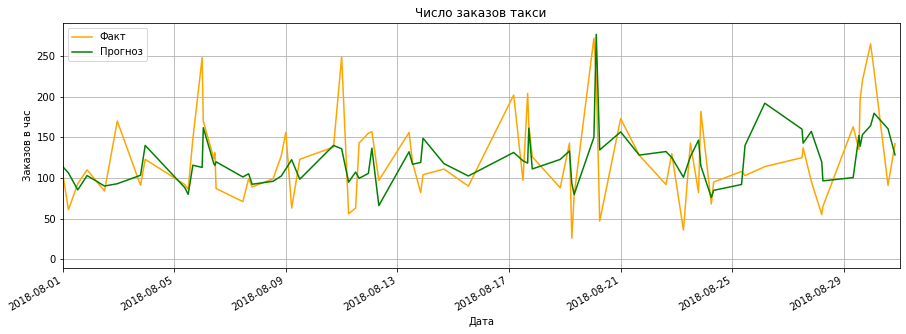

In [27]:
test_model(model_best_params['LASSO_model'], features_test, target_test)

<u><b>Тестирование регрессии случайного леса</b></u>

Значение RMSE на тестовой выборке: 25.561594087818772


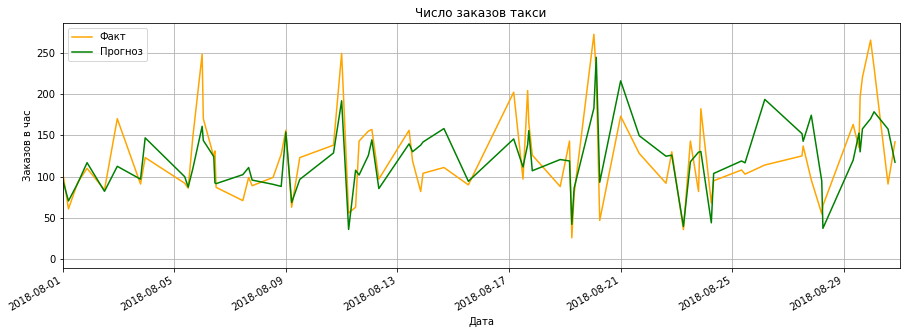

In [28]:
test_model(model_best_params['RFR_model'], features_test, target_test)

<u><b>Тестирование LightGBR </b></u>

Значение RMSE на тестовой выборке: 23.691784041432328


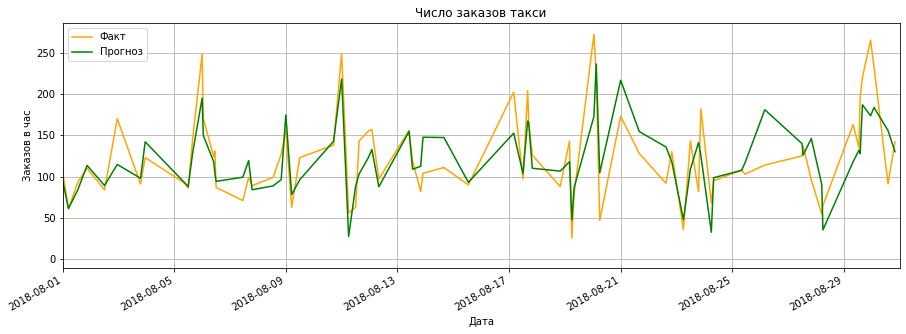

In [29]:
test_model(model_best_params['LGBR_model'], features_test, target_test)

<u><b>Тестирование CatBoost </b></u>

Значение RMSE на тестовой выборке: 23.631261549308384


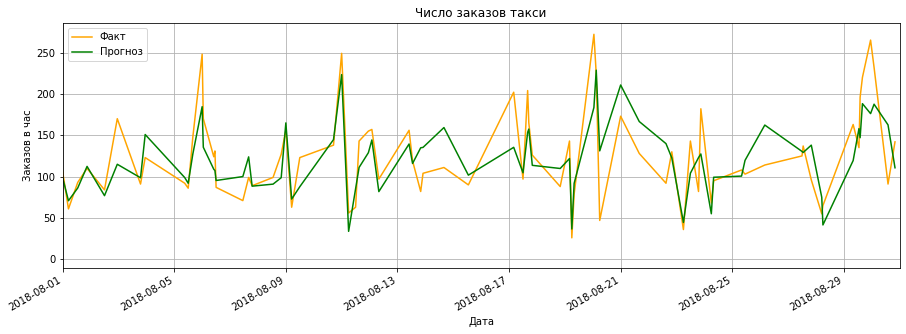

In [30]:
test_model(model_best_params['CB_model'], features_test, target_test)

Итоговые результаты можелирования сведены в таблицу ниже.

In [31]:
RMSE_summary = pd.DataFrame(columns=['Lin Regression', 'LASSO', 'RF Regresson', 'LightGBM', 'CatBoost_model'],
                           index=['Train speed, sec.', 'RMSE_train', 'RMSE_valid'],
                           data=([model_speed_train['LR_model'], model_speed_train['LASSO_model'], model_speed_train['RFR_model'], model_speed_train['LGBR_model'], model_speed_train['CB_model']],
                                 [model_score_train['LR_model'], model_score_train['LASSO_model'], model_score_train['RFR_model'], model_score_train['LGBR_model'], model_score_train['CB_model']],
                                 [model_score_valid['LR_model'], model_score_valid['LASSO_model'], model_score_valid['RFR_model'], model_score_valid['LGBR_model'], model_score_valid['CB_model']]
                                ))

RMSE_summary

,Lin Regression,LASSO,RF Regresson,LightGBM,CatBoost_model
"Train speed, sec.",0.144353,0.416858,16.181524,4.456557,13.899220
RMSE_train,33.405806,33.389220,26.830382,26.093929,26.137815
RMSE_valid,35.631066,35.615878,28.013388,26.753810,26.691804


## 4. Итоги исследования

Был осуществлен анали данных о заказах такси в период с 2018-03-01 по 2018-08-31, с учетом декомпозиции на трендовую, сезонную и стохастическую составляющие.
<p>На основании анализа были обоснованы и подготовлены признаки для дальнейшего построния предсказательных моделей. Цель моделирования состояла в прогнозировании числа заказов такси в ближайший час.
При моделировании были учтены следующие факторы: дневная сезонность, зависимость от дня недели, двухчасовая авторегрессия и тренд последних 24 часов.</p>
<p>На этих признаках были построены 5 моделей: 2 линейных - линейная регрессия, LASSO; 1 ансамблевая - случайный лес, а также две бустинговые модели - LightGBM и CatBoost.</p>
<br>Обучение, валидация и тестирование моделей позволяют сделать следующие выводы:

- Все модели справились с достижением RMSE менее 48 заказов/час.
- Наибольшее время для обучения потребовалось модели LightGBM (37 сек), при этом линейные модели без сложных параметров были обучены мене чем за 2 сек.
- Наилучший результат показала модель CatBoost, достигнув минимального значения RMSE в 26, заказа/час на валидационной выборке и 23,6 - на тестовой выборке.